# <span style="color:#F72585"><center>Entendiendo el HDBSCAN y la agrupación en clústeres basada en la densidad</center></span>

*Nota:* Este Jupyter Notebook esta basada en la lectura de Towards Data Science por [Pepe Berba](https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e)

El objetivo principal de esta sección es mostrar los conceptos clave que te ayudarán a comprender cómo y por qué funciona el algoritmo de agrupamiento HDBSCAN.
 
Recordemos que el algoritmo HDBSCAN es una técnica de agrupamiento robusta y basada en densidades, así que como tal, podemos advertir que a priori no tenemos ningún supuesto que verificar.

Empecemos por lo más alto. Antes incluso de describir nuestro algoritmo de agrupamiento, debemos preguntarnos, "¿qué tipo de datos estamos tratando de agrupar?" Queremos tener la menor cantidad posible de suposiciones sobre nuestros datos. Quizás las únicas suposiciones que podemos hacer con seguridad son:

1. Hay ruido en nuestros datos
2. Hay grupos en nuestros datos que esperamos descubrir

In [1]:
import hdbscan
import numpy as np
import pandas as pd
import sklearn.cluster as cluster
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
import time
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}


Con el fin de motivar la explicación del HDBSCAN, arrancaremos mostrando los datos obtenidos de *chaca chaca* los cuales vemos a continuacion:

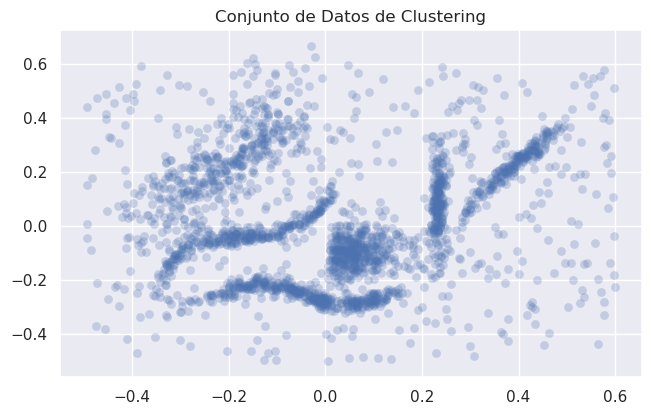

In [2]:
data = np.load('./Data/clusterable_data.npy')
plt.subplots(figsize =(7.5, 4.5))
plt.title('Conjunto de Datos de Clustering')
plt.scatter(data.T[0], data.T[1], **plot_kwds)

Este conjunto de datos tiene únicamente 2 dimensiones, lo cual lo convierte en un ejemplo fácil para detectar los clusters a simple vista. Es así que podemos identificar fácilmente "6" clusters, ahora nuestro siguiente paso es detectarlos por medio de un algoritmo de clustering.  

## <span style="color:#4361EE">K-means vs HDBSCAN</span>

Conociendo el número esperado de grupos, ejecutamos el algoritmo clásico de K-means y comparamos las etiquetas resultantes con las obtenidas usando HDBSCAN.

In [3]:
def plot_clusters(data, algorithm, args, kwds):
    #start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    #end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    plt.title('Clusters encontrados por {}'.format(str(algorithm.__name__)), fontsize=17)
    #plt.text(-0.5, 0.68, 'Clustering tomo {:.2f} s'.format(end_time - start_time), fontsize=10)

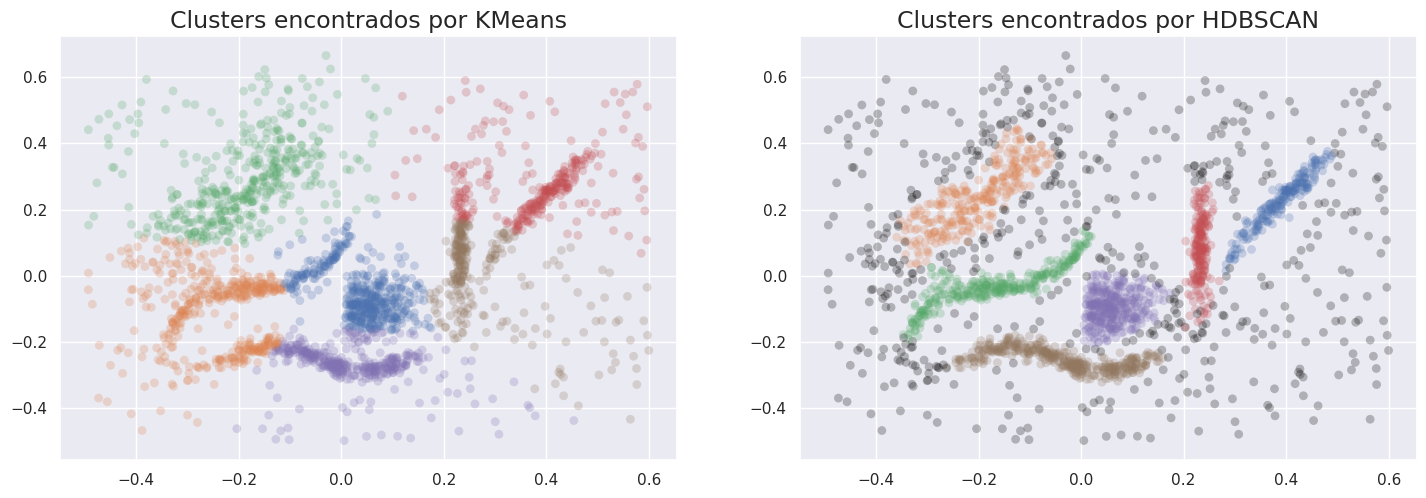

In [4]:
plt.subplots(figsize = (17.5, 5.5))
plt.subplot(1, 2, 1)
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})
plt.subplot(1, 2, 2)
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

Incluso cuando se proporciona el número correcto de grupos, K-means claramente no logra agrupar los datos en grupos útiles. HDBSCAN, por otro lado, nos da la agrupación esperada.

## <span style="color:#4361EE">¿Por qué el algoritmo K-Means falla?</span>

Brevemente, **K-means tiene un desempeño deficiente porque no se cumplen los supuestos subyacentes sobre la forma de los conglomerados**; es un algoritmo paramétrico parametrizado por los centroides del grupo K, los centros de las esferas gaussianas. K-means funciona mejor cuando los clústeres son:
1. Esferícos o semi-esferícos
2. De igual tamaño
3. Con la misma densidad
4. Con mayor densidad hacia el centro de la esfera o esferoide
5. Datos no contaminados por ruido i.e., pocos o nulos datos atipicos

Tomemos prestado un ejemplo más simple de (Hastie. et al., 2009) para ilustrar cómo las K-medias pueden ser sensibles a la forma de los conglomerados. A continuación se muestran dos agrupaciones a partir de los mismos datos. A la izquierda, los datos se estandarizaron antes de la agrupación. Sin estandarización, obtenemos una agrupación "errónea".


In [5]:
centers = [ [-1, 0], [1, 0]]
X, y = make_blobs(
        n_samples    = 200, 
        n_features   = 2, 
        centers      = centers, 
        cluster_std  = 0.9, 
        random_state = 100
       )
transformation = [[1, 0], [0,1/(1/(2*0.9))]]
X_aniso = np.dot(X, transformation)

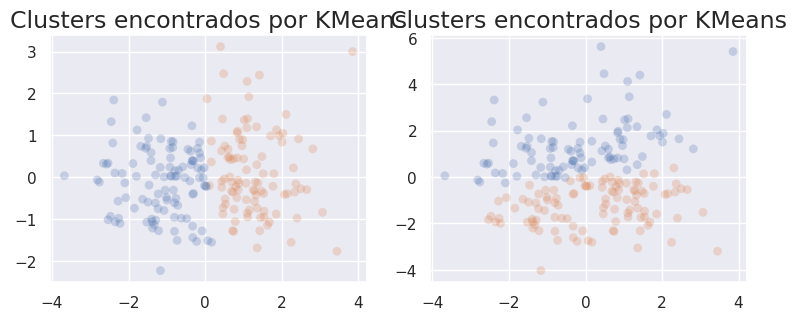

In [6]:
plt.subplots(figsize = (9, 3.2))
plt.subplot(1, 2, 1)
plot_clusters(X, cluster.KMeans, (), {'n_clusters':2})
plt.subplot(1, 2, 2)
plot_clusters(X_aniso, cluster.KMeans, (), {'n_clusters':2})

Datos simulados: a la izquierda, se ha aplicado el agrupamiento de K-medias (con $K=2$) a los datos sin procesar. Los dos colores indican cada uno de los clusters encontrados. A la derecha, los datos han sido estandarizados antes de agruparse. Esto es equivalente a usar ponderaciones $1/[2\text{Var}(X_j )]$ para los datos. La estandarización ha aumentado la dispersión de los datos ocasionando que el algoritmo no trabaje de forma óptima. Tenga en cuenta que cada gráfico utiliza las mismas unidades en los ejes horizontal y vertical.

$\textbf{Figura 1}$ (Izquierda) Clusters formados con los datos estandarizados vs (Derecha) Clusters formados con los datos sin estandarizar

## <span style="color:#4361EE">¿Cuáles son las características de nuestros datos?</span>

Volvemos a nuestro conjunto de datos original y simplemente describiéndolo, se vuelve obvio por qué K-means tiene dificultades. El conjunto de datos tiene:

1. Clústeres con formas arbitrarias
2. Clústeres de distintos tamaños
3. Clústeres con diferentes densidades
4. Algo de ruido y tal vez algunos valores atípicos

<figure>
<center>
<img src="Images/cdata.png", width = 600, height = 400 align="center" /> 
</center>   
</figure>

## <span style="color:#4361EE">Necesidad de robustez para la exploración de datos</span>

Si bien cada una de las observaciones se puede provenir de un conjunto de datos del mundo real, cada uno de ellos puede llegar a suponer un problema para algoritmos paramétricos como K-means. Es posible que deseemos verificar si se cumplen las suposiciones de nuestros algoritmos antes de confiar en su salida. Pero verificar estas suposiciones puede ser difícil cuando se sabe poco sobre los datos. Esto es desafortunado porque uno de los usos principales de los algoritmos de agrupamiento es la exploración de datos donde todavía estamos en el proceso de comprender los datos.

Por lo tanto, un algoritmo de agrupamiento que se utilizará para la exploración de datos debe tener la menor cantidad de suposiciones posible para que los conocimientos iniciales que obtengamos sean "útiles"; tener menos suposiciones lo hace más sólido y aplicable a una gama más amplia de datos del mundo real.

## <span style="color:#4361EE">Regiones densas y modas multivariadas</span>

Ahora que tenemos una idea de qué tipo de datos estamos tratando, exploremos las ideas centrales de HDBSCAN y cómo sobresale incluso cuando los datos tienen:

1. Clústeres de forma arbitraria
2. Clústeres con diferentes tamaños y densidades
3. Ruido

HDBSCAN utiliza un enfoque basado en la densidad que hace pocas suposiciones implícitas sobre los clústeres. Es un método no paramétrico que busca una jerarquía de conglomerados conformada por los modos multivariados de la distribución subyacente. En lugar de buscar grupos con una forma particular, busca regiones de los datos que sean más densas que el espacio circundante. La imagen mental que puedes utilizar es intentar separar las islas del mar o las montañas de sus valles.

<figure>
<center>
<img src="Images/densedta.png", width = 600, height = 400 align="center" /> 
</center>   
</figure>

Una forma de definir un cluster que suele ser consistente con nuestra noción intuitiva de conglomerados es: regiones muy densas separadas por regiones dispersas.

In [7]:
def create_mixtures(pis, mus, Sigmas, N=5000, rseed = None):
    if rseed is not None:
        np.random.seed(rseed)
    points = list()
    labels = list()
    for k in range(len(pis)):
        Nc = int(pis[k]*N)
        if len(mus[k]) > 1:
            x = np.random.multivariate_normal(mus[k], Sigmas[k], Nc)
        else:
            x = mus[k] + np.sqrt(Sigmas[k])*np.random.randn(Nc)
        points.append(x)
        labels.append([k]*Nc)
    return np.concatenate(points), np.concatenate(labels)

In [8]:
data, labels = create_mixtures(pis = [0.3, 0.2, 0.4],
                               mus =[[0.5], [2.4], [5]],
                               Sigmas = [0.1, 0.1, 0.26],
                               rseed = 4)                             

La siguiente grafica obtenida con datos simulados, muestra claramente 3 clusters

[Text(0.5, 1.0, 'Stripplot de X')]

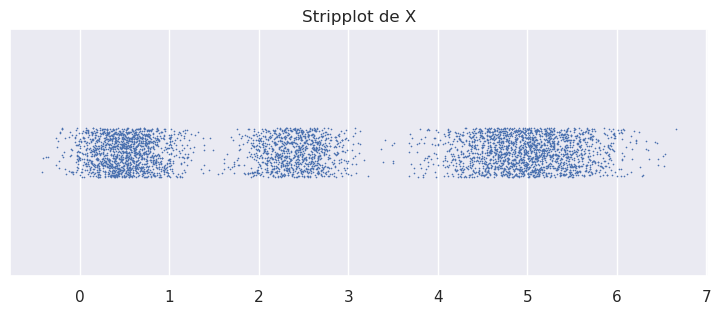

In [9]:
plt.subplots(figsize = (9, 3.2))
sns.stripplot(x =data, size = 1.2).set(title ='Stripplot de X')

<figure>
<center>
<img src="Images/3dense.png" align="center" /> 
</center>   
</figure>

## <span style="color:#4361EE">En búsqueda de la distribución subyacente</span>

$X$ son datos simulados de una mezcla de distribuciones normales, y por lo tanto somos capaces de graficar la distribución exacta de $X$.

[Text(0.5, 1.0, 'Densidad de Mixturas Gaussianas')]

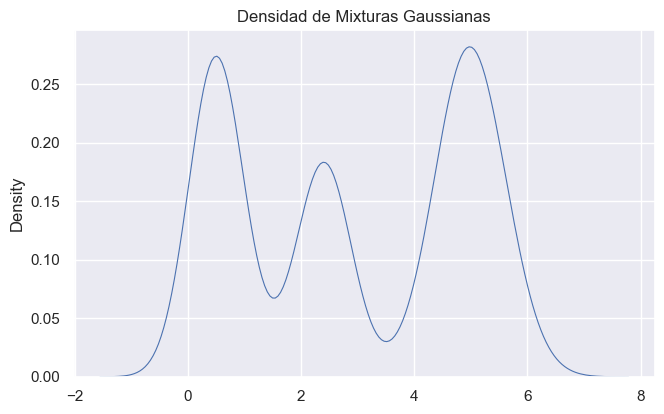

In [ ]:
plt.subplots(figsize = (7.5, 4.5))
sns.kdeplot(data, linewidth=0.8).set(title = "Densidad de Mixturas Gaussianas")

<figure>
<center>
<img src="Images/dise.png", width = 600, height = 400 align="center" /> 
</center>   
</figure>

Los picos corresponden a las regiones más densas y los valles corresponden a las regiones dispersas. Esto nos da otra forma de enmarcar el problema suponiendo que conocemos la distribución subyacente, los conglomerados son regiones altamente probables separadas por regiones improbables. Imagine las distribuciones de probabilidad de dimensiones superiores formando un paisaje de montañas y valles, donde las montañas son sus clusters.

<figure>
<center>
<img src="Images/dense1.png", width = 500, height = 300 align="center" /> 
</center>   
</figure>


Para aquellos que no estén tan familiarizados con terminos estadísticos, las dos afirmaciones siguientes son prácticamente iguales:

1. regiones muy densas separadas por regiones escasas
2. regiones altamente probables separadas por regiones improbables

La principal diferencia esta, en que uno describe los datos a través de su distribución de probabilidad y el otro a través de una muestra aleatoria de esa distribución.

El gráfico FDP y el gráfico de strip plot de arriba son equivalentes. La FDP, función de densidad de probabilidad, se interpreta como la probabilidad de estar dentro de una pequeña región alrededor de un punto, y cuando se observa una muestra de $X$, también se puede interpretar como la densidad esperada alrededor de ese punto.

Dada la distribución subyacente, esperamos que las regiones que son más probables tiendan a tener más puntos (más densas) en una muestra aleatoria. De manera similar, dada una muestra aleatoria, puede hacer inferencias sobre la probabilidad de una región en función de la densidad empírica.

**Las regiones más densas en la muestra aleatoria corresponden a regiones más probables en las distribuciones subyacentes.**

De hecho, si observamos el histograma de una muestra aleatoria de $X$, vemos que se parece exactamente a la verdadera distribución de $X$. El histograma a veces se denomina distribución de probabilidad empírica y, con suficientes datos, esperamos que el histograma converja a la verdadera distribución subyacente.

[Text(0.5, 1.0, 'Histograma de X')]

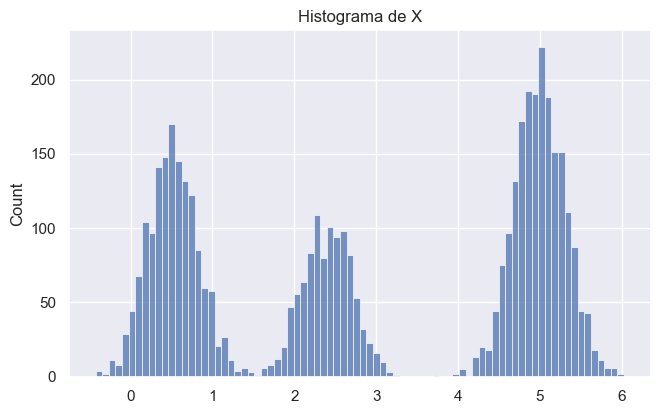

In [ ]:
sns.histplot(data, kde = False, bins = 80).set(title = 'Histograma de X')

De nuevo, densidad = probabilidad. Más denso = más probable.

Lamentablemente, incluso con nuestra definición intuitiva de clusters como "montañas y valles", puede ser difícil saber si algo es o no un cluster único. Miremos el ejemplo a continuación donde trasladamos a la derecha una de las modas de $X$. Aunque todavía tenemos 3 picos, ¿tenemos 3 grupos? En algunos contextos, podríamos considerar 3 grupos. "Intuitivamente" decimos que solo hay 2 grupos. Entonces ¿cómo decidimos?

In [ ]:
data, labels = create_mixtures(pis = [0.3, 0.2, 0.4],
                               mus =[[1], [2.4], [5]],
                               Sigmas = [0.12, 0.12, 0.26],
                               rseed = 4)  

[Text(0.5, 1.0, 'Densidad de Mixturas Gaussianas con una Moda desplazada')]

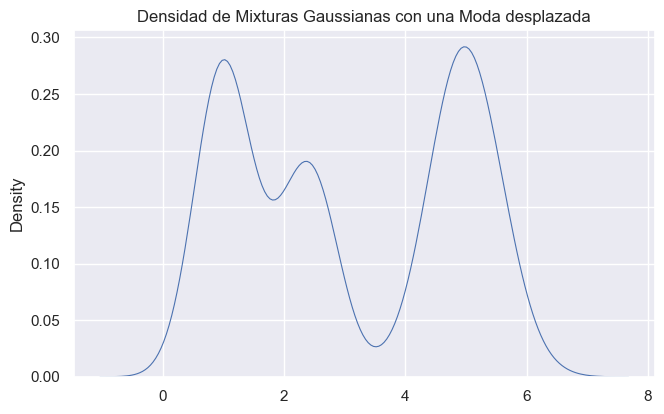

In [ ]:
plt.subplots(figsize = (7.5, 4.5))
sns.kdeplot(data, linewidth=0.8).set(title = "Densidad de Mixturas Gaussianas con una Moda desplazada")

Al mirar el grafico *strip plot* de $X$, podemos estar un poco más seguros de que solo hay 2 grupos.

[Text(0.5, 1.0, 'Stripplot de X desplazada')]

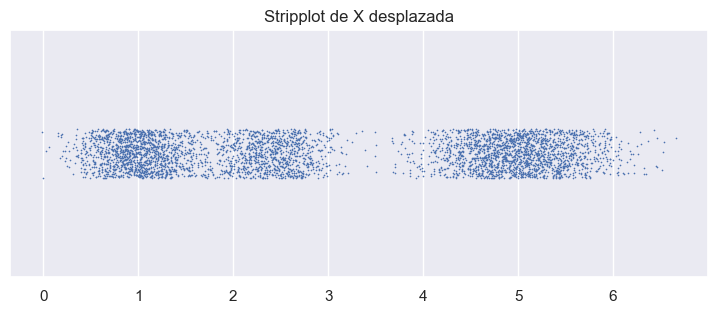

In [ ]:
plt.subplots(figsize = (9, 3.2))
sns.stripplot(x =data, size = 1.2).set(title ='Stripplot de X desplazada')

$X$ tiene 3 grupos y $X$ tiene 2 grupos. ¿En qué punto cambia el número de clusters?

Una forma de definir esto es establecer algún umbral global para el FDP de la distribución subyacente. *"Los componentes conectados de los conjuntos de niveles resultantes son sus grupos"* [1]. Esto es lo que hace el algoritmo DBSCAN, y hacerlo en múltiples niveles daría como resultado HDBSCAN [4].

<figure>
<center>
<img src="Images/dense5.png", width = 600, height = 250 align="center" /> 
</center>   
</figure>

Esto puede ser atractivo por su simplicidad, ¡pero no se deje engañar! Terminamos con un hiperparámetro adicional, el umbral $\lambda$, que quizás tengamos que ajustar. Además, esto no funciona bien para grupos con diferentes densidades.

Para ayudarnos a elegir, coloreamos nuestras opciones de grupos como se muestra en la siguiente ilustración. ¿Deberíamos considerar azul y amarillo, o solo verde?

<figure>
<center>
<img src="Images/dense6.png", width = 600, height = 250 align="center" /> 
</center>   
</figure>

Para elegir, nos fijamos en cuál “persiste” más. ¿Los vemos más juntos o separados? Podemos cuantificar esto usando el área de las regiones coloreadas.

A la izquierda, vemos que la suma de las áreas de las regiones azul y amarilla es mayor que el área de la región verde. Esto significa que los 2 picos son más prominentes, por lo que decidimos que son dos grupos separados.

A la derecha, vemos que el área de verde es mucho más grande. Esto significa que son solo "baches" en lugar de picos. Entonces decimos que son solo un grupo.

En la literatura [2], el área de las regiones es la medida de persistencia, y el método se llama eom o exceso de masa. Un poco más formal, maximizamos la suma total de persistencia de los grupos bajo la restricción de que los grupos elegidos no se superponen.

## <span style="color:#4361EE">Construyendo la jerarquía</span>

Al obtener múltiples conjuntos de niveles en diferentes valores de $\lambda$, obtenemos una jerarquía. Para un escenario multidimensional, imagina que los grupos son islas en medio del océano. A medida que baja el nivel del mar, las islas comenzarán a “crecer” y eventualmente las islas comenzarán a conectarse entre sí.

Para poder capturar y representar estas relaciones entre clusters (islas), lo representamos como un árbol de jerarquía. Esta representación se generaliza a dimensiones superiores y es una abstracción natural que es más fácil de representar como una estructura de datos que podemos atravesar y manipular.

<figure>
<center>
<img src="Images/dense7.png", width = 600, height = 250 align="center" /> 
</center>   
</figure>

Al usar HDBSCAN, este gráfico en particular puede ser útil para evaluar la calidad de sus clústeres y puede ayudar a ajustar los hiperparámetros, como veremos en la sección "Selección de parámetros".

## <span style="color:#4361EE">Densidad de aproximación local </span>

En la sección anterior, tuvimos acceso al FDP real de la distribución subyacente. Sin embargo, la distribución subyacente casi siempre se desconoce para los datos del mundo real.

Por lo tanto, tenemos que estimar la FDP utilizando la densidad empírica. Ya discutimos una forma de hacer esto, usando un histograma. Sin embargo, esto solo es útil para datos unidimensionales y se vuelve computacionalmente intratable a medida que aumentamos el número de dimensiones.

Necesitamos otras formas de obtener el PDF empírico. Aquí hay dos formas:

1. Contar el número de vecinos de un punto particular dentro de su radio-$\varepsilon$
2. Encontrar la distancia al K-ésimo vecino más cercano (que es lo que usa HDBSCAN)

### <span style="color:#4CC9F0">Contando vecinos dentro del radio-$\varepsilon$</span>

Para cada punto, dibujamos una hiperesfera de radio $\varepsilon$ alrededor del punto y contamos el número de puntos dentro de ella. Esta es nuestra aproximación local de la densidad en ese punto del espacio.

<figure>
<center>
<img src="Images/dense8.png", width = 600, height = 270 align="center" /> 
</center>   
</figure>

Hacemos esto para cada punto y comparamos la FDP estimada con el valor real de la FDP (que ahora solo hacemos porque simulamos los datos y su distribución es algo que definimos).

Para nuestros datos simulados unidimensionales, el conteo de vecinos está altamente correlacionado con el valor real del FDP. Cuanto mayor sea el número de vecinos, mayor será el PDF estimado.

<figure>
<center>
<img src="Images/dense9.png" align="center" /> 
</center>   
</figure>

Vemos que este método da como resultado buenas estimaciones de la FDP para nuestros datos simulados $X$. Tenga en cuenta que esto puede ser sensible a la escala de los datos y al tamaño de la muestra. Es posible que debas iterar sobre varios valores de $\varepsilon$ para obtener buenos resultados.

### <span style="color:#4CC9F0">Distancia al K-ésimo vecino más cercano </span>

En este, obtenemos el complemento del enfoque anterior. En lugar de establecer $\varepsilon$ y luego contar los vecinos, determinamos el número de vecinos que queremos y encontramos el valor más pequeño de $\varepsilon$ que contendría estos K vecinos.

<figure>
<center>
<img src="Images/dense10.png", width = 600, height = 300 align="center" /> 
</center>   
</figure>

Los resultados son lo que llamamos distancias centrales en HDBSCAN. Los puntos con distancias centrales más pequeñas se encuentran en regiones más densas y tendrían una estimación alta para la PDF. Los puntos con distancias centrales más grandes se encuentran en regiones más dispersas porque tenemos que viajar distancias más grandes para incluir suficientes vecinos.

<figure>
<center>
<img src="Images/dense11.png" align="center" /> 
</center>   
</figure>

Intentamos estimar la FDP en nuestros datos simulados $X$. En las gráficas anteriores, usamos $1/d_{core}(\cdot)$ como la estimación de la FDP. Como era de esperar, las estimaciones están altamente correlacionadas con la FDP real.

Mientras que el método anterior era sensible tanto a la escala de los datos como al tamaño del conjunto de datos, este método es principalmente sensible al tamaño del conjunto de datos. Si escala cada dimensión por igual, todas las distancias centrales aumentarán proporcionalmente.

La conclusión clave aquí es:

1. distancia del núcleo = estimación de la densidad
2. (recuerde que) densidad = probabilidad
3. **distancia del núcleo = alguna estimación de la FDP**

Entonces, cuando nos referimos a la distancia central de un punto, puede pensar en referirse implícitamente al FDP. Filtrar puntos en función de la distancia del núcleo $d_{core}(\cdot)$ es similar a obtener un conjunto de niveles de la distribución subyacente.

Cada vez que tenemos $d_{core}(\cdot) \leq \varepsilon$, está ocurriendo implicitamente que $f(x) \geq \lambda$, donde $f(x)$ es la función de densidad de probabilidad. Siempre hay una correlación entre $\varepsilon$ y $\lambda$, y solo usaremos el símbolo $\lambda$ tanto para las distancias entre núcleos como para la PDF por simplicidad.

## <span style="color:#4361EE">Encontrando los niveles para cada conjunto y coloreando las regiones</span>

Recuerde que en los ejemplos anteriores, obtenemos un conjunto de niveles del FDP y las regiones resultantes son nuestros grupos. Esto fue fácil porque una región se representó como una forma. Pero cuando estamos tratando con puntos, ¿cómo sabemos cuáles son las diferentes regiones?

Tenemos un pequeño conjunto de datos a la izquierda y su FDP correspondiente a la derecha.

<figure>
<center>
<img src="Images/dense12.png", width = 600, height = 250 align="center" /> 
</center>   
</figure>

El primer paso es encontrar el conjunto de niveles en algún valor de  $\lambda$. Filtramos por regiones $f(x) \geq \lambda$ o filtramos por puntos con $d_{core}(\cdot) \leq \lambda$ .

<figure>
<center>
<img src="Images/dense13.png", width = 600, height = 250 align="center" /> 
</center>   
</figure>

Ahora necesitamos encontrar las diferentes regiones. Esto se hace conectando puntos "cercanos" entre sí. “Cerca” está determinada por el nivel de densidad actual definido por $\lambda$ y decimos que dos puntos están lo suficientemente cerca si su distancia euclidiana es menor que $\lambda$.

Dibujamos una esfera de radio $\lambda$ alrededor de cada punto.

<figure>
<center>
<img src= "Images/dense14.png", width = 630, height = 250 align="center" /> 
</center>   
</figure>

Conectamos el punto con todos los puntos dentro de su esfera-$\lambda$. Si dos puntos están conectados, pertenecen a la misma región y deben tener el mismo color.


<figure>
<center>
<img src="Images/dense15.png", width = 630, height = 250 align="center" /> 
</center>   
</figure>



Haga esto para cada punto y lo que nos queda son varios componentes conectados. Estos son nuestros clústeres.

<figure>
<center>
<img src="Images/dense16.png", width = 600, height = 250 align="center" /> 
</center>   
</figure>

Estos son los clusters que se obtienen para algún nivel establecido. Seguimos "bajando el mar" y seguimos la pista a medida que aparecen nuevos grupos, algunos grupos crecen y, finalmente, algunos se fusionan.

## <span style="color:#4361EE">Bajando el nivel del mar</span>

Aquí hay cuatro visualizaciones donde mostramos 4 clusters en 4 conjuntos de niveles diferentes. Realizamos un seguimiento de los diferentes grupos para que podamos construir el árbol de jerarquía que hemos discutido anteriormente.

<figure>
<center>
<img src="Images/eg1.png" align="center" /> 
</center>   
</figure>
<figure>
<center>
<img src="Images/eg2.png" align="center" /> 
</center>   
</figure>
<figure>
<center>
<img src="Images/eg3.png" align="center" /> 
</center>   
</figure>
<figure>
<center>
<img src="Images/eg4.png" align="center" /> 
</center>   
</figure>

## <span style="color:#4361EE">Definición de una nueva métrica de distancia</span>

Nos gustaría resaltar que los puntos pueden estar dentro de la esfera $\lambda$ pero aún así no estarán conectados. Primero deben incluirse en el conjunto de niveles, por lo que $\lambda$ debe ser mayor que su distancia central para que se considere el punto.

<figure>
<center>
<img src="Images/dense17.png", width = 600, height = 250 align="center" /> 
</center>   
</figure>

El valor de $\lambda$ en el que dos puntos finalmente se conectaron puede interpretarse como una nueva distancia. Para que dos puntos estén conectados deben ser:

1. En una región lo suficientemente densa
2. Lo suficientemente cerca el uno del otro

Para $\textbf{a}$ y $\textbf{b}$, obtenemos las siguientes desigualdades en términos de $\lambda$ :

1. $d_{core}(\textbf{a}) \leq \lambda$
2. $d_{core}(\textbf{b}) \leq \lambda$
3. $d(\textbf{a}, \textbf{b}) \leq \lambda$
(1) y (2) son para la sentencia "En una región suficientemente densa". (3) es para la sentencia "lo suficientemente cerca el uno del otro"

Combinando estas desigualdades, el valor más pequeño de $\lambda$ necesario para poder conectar directamente $\textbf{a}$ y $\textbf{b}$ es:

$$d_{mreach}\left(\textbf{a}, \textbf{b}\right) = \text{Max}\left\{ d_{core}\left(\textbf{a} \right), d_{core}\left(\textbf{b} \right),d\left(\textbf{a}, \textbf{b}\right)\right\}$$

Esta se conoce como la distancia de accesibilidad mutua en la literatura de HDBSCAN.

## <span style="color:#4361EE">Proyección al espacio $\lambda$</span>

*Nota: Este “espacio lambda” es un término que no se encuentra en la literatura. Esto es solo para este cuaderno*.

En lugar de usar la distancia euclidiana como nuestra métrica, ahora podemos usar la distancia de accesibilidad mutua como nuestra nueva métrica. Usarlo como métrica es equivalente a incrustar los puntos en algún nuevo espacio métrico, que simplemente llamaríamos $\lambda$-espacio*.

<figure>
<center>
<img src="Images/dense18.png", width = 670, height = 250 align="center" /> 
</center>   
</figure>

Esto tiene el efecto de separar puntos cercanos en regiones dispersas.

Debido a la aleatoriedad de una muestra aleatoria, dos puntos pueden estar cerca uno del otro en una región muy dispersa. Sin embargo, esperamos que los puntos en regiones dispersas estén muy separados unos de otros. Al usar la distancia de accesibilidad mutua, los puntos en regiones dispersas “repelen a otros puntos” si están demasiado cerca, mientras que los puntos en regiones muy densas no se ven afectados.

A continuación, se muestra un gráfico de los puntos en el espacio $\lambda$ proyectados usando el escalado multidimensional para mostrar su efecto de forma más concreta.

<figure>
<center>
<img src="Images/dense19.png", width = 900, height = 350 align="center" /> 
</center>   
</figure>

Podemos ver este efecto repelente a la izquierda y arriba. Los cuatro puntos de la izquierda están más dispersos porque están en un espacio muy escaso.

## <span style="color:#4361EE">Construyendo el árbol jerárquico usando un espacio $\lambda$</span>

Recordemos que para construir el árbol de jerarquía, tenemos los siguientes pasos:

1. Establece $\lambda$ en el valor más pequeño de la distancia al núcleo
2. Filtrar por los puntos en el conjunto de niveles
3. Conectar puntos que están a lo sumo $\lambda$ unidades de distancia
4. Crear nuevos clústeres, expandir nuevos clústeres y fusionar clústeres
5. Establezca $\lambda$ en el siguiente valor más pequeño de la distancia del núcleo y vaya al paso (2)

Note que al hacer el paso (3), conectar dos puntos que ya pertenecen al mismo componente conectado es inútil. Lo que realmente importa son las conexiones entre clústeres. La conexión que conectaría dos clústeres corresponde al par de puntos de dos clústeres diferentes con la menor distancia de alcance mutuo. Si ignoramos estas conexiones "inútiles" y solo notamos las relevantes, lo que nos queda es una lista ordenada de bordes que siempre fusionan dos grupos (componentes conectados).

<figure>
<center>
<img src="Images/dense20.png", width = 600, height = 250 align="center" /> 
</center>   
</figure>

Esto puede parecer complicado, pero se puede simplificar si consideramos la distancia de accesibilidad mutua como nuestra nueva métrica:

1. Incruste los puntos en el espacio $\lambda$ y considere cada punto como un grupo separado
2. Encuentre la distancia más corta entre dos puntos de dos grupos diferentes
3. Fusionar los dos clústeres
4. Vuelva al paso (2) hasta que solo haya un grupo

Si esto te suena familiar, es el agrupamiento aglomerativo clásico. ¡Este es solo el agrupamiento de enlace único en el espacio $\lambda$!

Hacer un agrupamiento de enlace único en el espacio euclidiano puede ser sensible al ruido, ya que los puntos ruidosos pueden formar puentes falsos entre islas. Al incrustar los puntos en el espacio $\lambda$, el "efecto repelente" hace que el agrupamiento sea mucho más resistente al ruido.

¡La agrupación en clústeres de enlace único es convenientemente equivalente a construir un árbol de expansión mínimo! Entonces podemos usar todas las formas eficientes de construir el MST(Minimum spanning tree) o en español árbol de expansión mínima a partir de la teoría de grafos.